# Task 1

In [1]:
import numpy as np
from scipy.optimize import minimize

# Given data
x = np.array([1, 1, 1, 6, 1, 1])

# Part 1: L2 minimization
def L2_loss(z):  # L2 loss function
    return np.sum((x - z)**2)

# Minimize the L2 loss function
z_hat_L2 = minimize(L2_loss, 0)

# Part 2: L1 minimization
def L1_loss(z):  # L1 loss function
    return np.sum(np.abs(x - z))

# Minimize the L1 loss function
z_hat_L1 = minimize(L1_loss, 0)
z_hat_L1_nongradient_method = minimize(L1_loss, 0, method='Nelder-Mead')

# Part 3: L0 minimization
def L0_loss(z):  # L0 loss function (counts non-zero differences)
    return np.sum(x != z)

# We try minimizing the L0 loss directly by looking at potential candidate values of z (the median in this case)
possible_z_values = np.unique(x)  # Candidates: unique values in x
L0_losses = [L0_loss(z) for z in possible_z_values]
print("possible z ... ",possible_z_values,"... possible L0 losses ... ",L0_losses)
z_hat_L0 = possible_z_values[np.argmin(L0_losses)]

print(z_hat_L2)
print("---------------")
print(z_hat_L1)
print("---------------")
print(z_hat_L1_nongradient_method)
print("---------------")

print("Final answers of L2, L1, L0 ")
print(z_hat_L2.x[0],z_hat_L1_nongradient_method.x[0], z_hat_L0)

possible z ...  [1 6] ... possible L0 losses ...  [1, 5]
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 20.83333333333333
        x: [ 1.833e+00]
      nit: 2
      jac: [ 0.000e+00]
 hess_inv: [[ 8.333e-02]]
     nfev: 6
     njev: 3
---------------
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 5.000000011605243
        x: [ 1.000e+00]
      nit: 2
      jac: [ 2.702e+00]
 hess_inv: [[ 7.704e-03]]
     nfev: 134
     njev: 61
---------------
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5.0000000000000036
             x: [ 1.000e+00]
           nit: 27
          nfev: 54
 final_simplex: (array([[ 1.000e+00],
                       [ 1.000e+00]]), array([ 5.000e+00,  5.000e+00]))
---------------
Final answers of L2, L1, L0 
1.833333314579837 1.0000000000000009 1


# Task 2

In [2]:
import torch
from transformers import CLIPProcessor, CLIPModel
from torchvision import datasets, transforms
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Set up device and load the CLIP model and processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load CIFAR-10 dataset with transformations for CLIP
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)  # Batch size 1

# Get class labels
class_labels = dataset.classes

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


100%|██████████| 170498071/170498071 [00:08<00:00, 20813944.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
class_labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [4]:
# Build the concept dictionary with some extended concepts
concept_words = class_labels + [
    'animal', 'vehicle', 'machine', 'boat', 'water', 'forest', 'sky', 'road', 'tree', 'hungry',
    'speed', 'travel', 'car', 'house', 'computer', 'track', 'snow', 'child', 'engine',
    'running', 'jumping', 'eating', 'sleeping', 'playing', 'mountain', 'beach',
     'love', 'fear','beauty', 'organism'
]

len(concept_words)

40

In [5]:
dataset[0][0].shape

torch.Size([3, 224, 224])

In [6]:
# Generate text embeddings for class labels
text_inputs = clip_processor(text=class_labels, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    text_features = clip_model.get_text_features(**text_inputs)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)  # Normalize text embeddings

# Generate image embeddings
image_embeddings = []
image_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        # Set do_rescale=False to avoid double scaling
        inputs = clip_processor(images=images, return_tensors="pt", do_rescale=False).to(device)
        image_features = clip_model.get_image_features(**inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)  # Normalize image embeddings
        image_embeddings.append(image_features)
        image_labels.extend(labels.numpy())

image_embeddings = torch.cat(image_embeddings).to(device)  # Shape: (num_images, 512)
image_labels = np.array(image_labels)  # Convert to NumPy arra


### Dense Embeddings Zero-Shot Classification ###

# Compute cosine similarity for dense embeddings
similarities = image_embeddings @ text_features.T  # Shape: (num_images, num_classes)
predicted_classes_dense = similarities.argmax(dim=1).cpu().numpy()

# Compute accuracy for dense embeddings
accuracy_dense = accuracy_score(image_labels, predicted_classes_dense)
print(f"Dense Embeddings Accuracy: {accuracy_dense * 100:.2f}%")

### Sparse Embeddings ###

# Encode concept words
concept_tokens = clip_processor(text=concept_words, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    concept_embeddings = clip_model.get_text_features(**concept_tokens)
    concept_embeddings = concept_embeddings / concept_embeddings.norm(dim=-1, keepdim=True)

# Center the embeddings
mean_image_embedding = image_embeddings.mean(dim=0, keepdim=True)
mean_concept_embedding = concept_embeddings.mean(dim=0, keepdim=True)

centered_image_embeddings = image_embeddings - mean_image_embedding
centered_concept_embeddings = concept_embeddings - mean_concept_embedding

# Prepare Ac matrix (concept embeddings) for Lasso
Ac = centered_concept_embeddings.cpu().numpy().T  # Shape: (embedding_dim, num_concepts)

# Define different lambda values for testing sparsity
alphas = [5e-7, 5e-6, 1e-5, 5e-5, 1e-4 ] #5e-4 and all values below it give 10% accuracy and 0 non zero values
accuracies_sparse = []
sparsity_levels = []

for alfa in alphas:
    print(f"Processing alpha = {alfa}")

    sparse_embeddings_list = []
    non_zero_counts = []
    all_sparse_weights = []

    for zc in centered_image_embeddings.cpu().numpy():
        # Lasso regression to solve for sparse weights
        lasso = Lasso(alpha=alfa, fit_intercept=False, max_iter=1000)
        lasso.fit(Ac, zc)
        w = lasso.coef_  # Sparse weights
        all_sparse_weights.append(w)

        # Count non-zero elements
        non_zero_count = np.count_nonzero(w)
        non_zero_counts.append(non_zero_count)

        # Reconstruct sparse embeddings
        z_hat = concept_embeddings.cpu().numpy().T @ w + mean_concept_embedding.cpu().numpy().flatten()
        sparse_embeddings_list.append(z_hat)

    # Convert list to tensor for similarity calculation
    sparse_embeddings = torch.from_numpy(np.array(sparse_embeddings_list).astype(np.float32)).to(device)
    sparse_embeddings = sparse_embeddings / sparse_embeddings.norm(dim=1, keepdim=True)  # Normalize

    # Zero-shot classification with sparse embeddings
    similarities_sparse = sparse_embeddings @ text_features.T
    predicted_classes_sparse = similarities_sparse.argmax(dim=1).cpu().numpy()

    # Compute accuracy for sparse embeddings
    accuracy_sparse = accuracy_score(image_labels, predicted_classes_sparse)
    accuracies_sparse.append(accuracy_sparse)

    # Compute average sparsity level
    avg_non_zero = np.mean(non_zero_counts)
    sparsity_levels.append(avg_non_zero)

    print(f"Sparse Embedding Accuracy: {accuracy_sparse * 100:.2f}%")
    print(f"Average number of non-zero elements: {avg_non_zero:.2f}\n")

Dense Embeddings Accuracy: 84.96%
Processing alpha = 5e-07
Sparse Embedding Accuracy: 60.26%
Average number of non-zero elements: 37.97

Processing alpha = 5e-06
Sparse Embedding Accuracy: 56.72%
Average number of non-zero elements: 28.98

Processing alpha = 1e-05
Sparse Embedding Accuracy: 53.84%
Average number of non-zero elements: 21.11

Processing alpha = 5e-05
Sparse Embedding Accuracy: 38.40%
Average number of non-zero elements: 2.09

Processing alpha = 0.0001
Sparse Embedding Accuracy: 14.73%
Average number of non-zero elements: 0.51



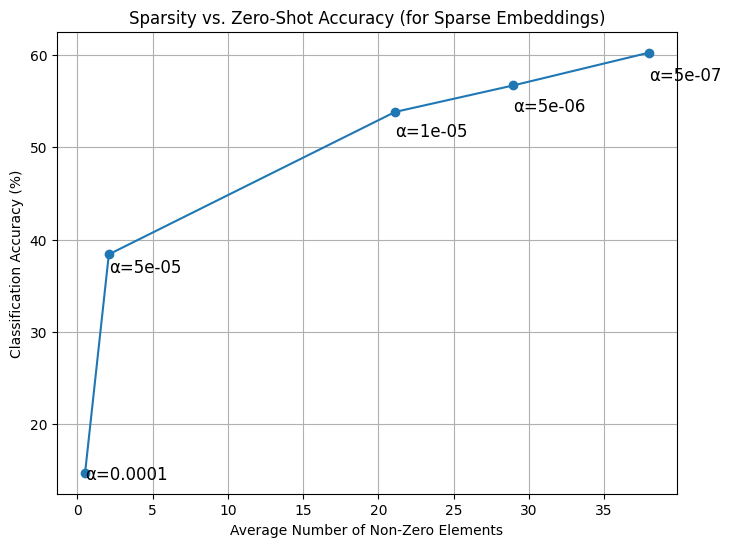

In [13]:
# Plot sparsity vs. accuracy
plt.figure(figsize=(8, 6))
plt.plot(sparsity_levels, [acc * 100 for acc in accuracies_sparse], marker='o')
plt.xlabel('Average Number of Non-Zero Elements')
plt.ylabel('Classification Accuracy (%)')
plt.title('Sparsity vs. Zero-Shot Accuracy (for Sparse Embeddings)')
for i, (x, y) in enumerate(zip(sparsity_levels, accuracies_sparse)):
    alpha_value = alphas[i]  # Fetch corresponding alpha
    plt.text(x, y * 95, f'α={alpha_value}', fontsize=12, ha='left')
plt.grid(True)
plt.show()

In [8]:
image_embeddings.shape, sparse_embeddings.shape, len(non_zero_counts), np.mean(non_zero_counts), len(sparsity_levels), np.mean(sparsity_levels), sparsity_levels

(torch.Size([10000, 512]),
 torch.Size([10000, 512]),
 10000,
 0.5083,
 5,
 18.129640000000002,
 [37.9667, 28.9801, 21.1069, 2.0862, 0.5083])

In [9]:
# Define sizes and memory per element
num_images, embedding_dim = image_embeddings.shape
bytes_per_float = 4  # 32-bit float
bytes_per_index = 4  # Assuming 32-bit integers for sparse indices

# Calculate the memory footprint for dense embeddings
memory_dense = num_images * embedding_dim * bytes_per_float

# Avg_non_zero is computed from non_zero_counts
avg_non_zero = np.mean(non_zero_counts)

# Calculate the memory footprint for sparse embeddings
memory_sparse = num_images * avg_non_zero * (bytes_per_float + bytes_per_index)

# Print memory usage for comparison
print(f"Memory footprint of Dense Embeddings: {memory_dense / (1024 ** 2):.2f} MB")
print(f"Memory footprint of Sparse Embeddings: {memory_sparse / (1024 ** 2):.2f} MB")
print(f"Average non-zero elements in sparse embeddings: {avg_non_zero:.2f}")

memory_savings = 100 * (1 - (memory_sparse / memory_dense))
print(f"Memory savings with sparse embeddings: {memory_savings:.2f}%")

Memory footprint of Dense Embeddings: 19.53 MB
Memory footprint of Sparse Embeddings: 0.04 MB
Average non-zero elements in sparse embeddings: 0.51
Memory savings with sparse embeddings: 99.80%


****Concept Extraction for CIFAR****

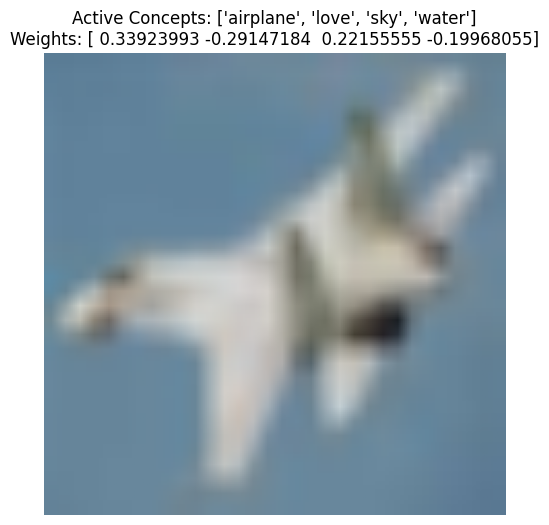

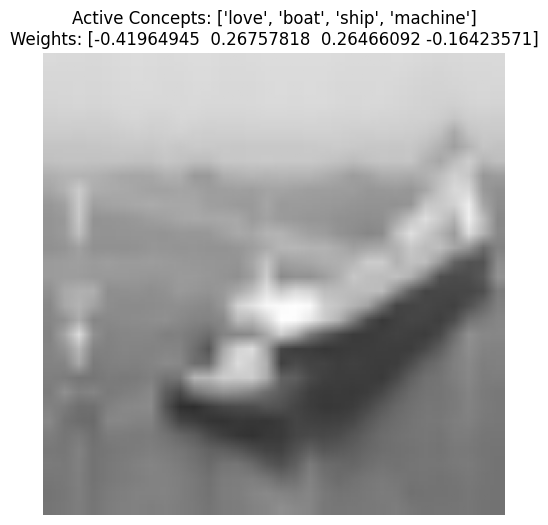

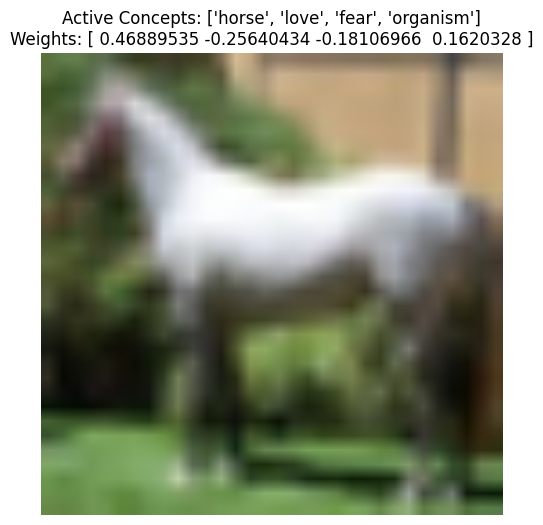

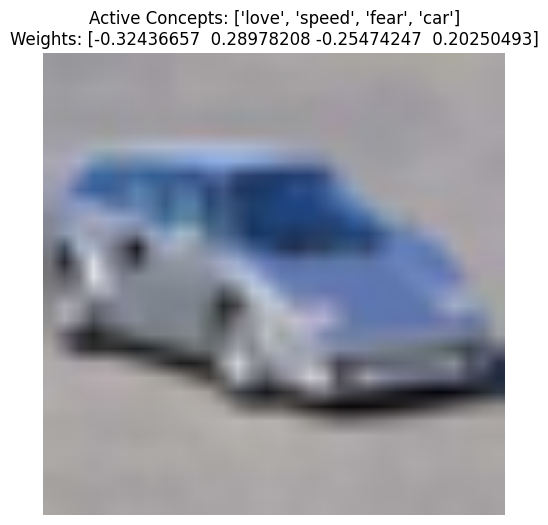

In [10]:
# Function to process a single image tensor from CIFAR and extract active concepts
def extract_concepts_cifar(index, top_k=4):
    image_tensor = dataset[index][0]  # Provide your (3, 224, 224) image tensor here
    image_embedding = image_embeddings[index]

    # Center the image embedding
    centered_image_embedding = image_embedding.cpu().numpy().flatten() - mean_concept_embedding.cpu().numpy().flatten()

    # Apply Lasso regression to get sparse weights
    lasso = Lasso(alpha=1e-5, fit_intercept=False, max_iter=1000)
    lasso.fit(Ac, centered_image_embedding)
    sparse_weights = lasso.coef_

    # Get active concepts (non-zero coefficients)
    active_concepts_indices = np.nonzero(sparse_weights)[0]
    # print(active_concepts_indices)
    top_indices = np.argsort(np.abs(sparse_weights[active_concepts_indices]))[-top_k:][::-1]
    limited_indices = active_concepts_indices[top_indices]

    # top_non_abs_indices = np.argsort(sparse_weights[active_concepts_indices])[-top_k:][::-1]
    # limited_indices = active_concepts_indices[top_non_abs_indices]

    # print(active_concepts_indices)
    # print(top_indices)
    # print(top_non_abs_indices)
    # print(limited_indices)
    # print(sparse_weights[active_concepts_indices])
    # print(sparse_weights[limited_indices])

    active_concepts = [concept_words[i] for i in limited_indices]
    active_weights = sparse_weights[limited_indices]

    return image_tensor, active_concepts, active_weights

#for an image
# for _ in range(30):
#   image_index = np.random.randint(0, 10000)
#   image_tensor, active_concepts, weights = extract_concepts_cifar(image_index)
#   plt.figure(figsize=(6, 6))
#   plt.imshow(image_tensor.permute(1, 2, 0).cpu())
#   plt.axis('off')
#   plt.title(f'IMG{image_index} Active Concepts: {active_concepts}\nWeights: {weights}')
#   plt.show()

#for multiple images
for idx in [10,120,3266,1621]:
  image_tensor, active_concepts, weights = extract_concepts_cifar(idx)
  plt.figure(figsize=(6, 6))
  plt.imshow(image_tensor.permute(1, 2, 0).cpu())
  plt.axis('off')
  plt.title(f'Active Concepts: {active_concepts}\nWeights: {weights}')
  plt.show()


**Concept Extraction for Non CIFAR**

In [11]:
!wget -O dummy_img.jpg https://cdn11.bigcommerce.com/s-t04x4i8lh4/product_images/uploaded_images/how-to-exercise-your-dog-in-the-winter.jpg
!wget -O dummy_img_2.jpg https://unsplash.com/photos/wLp1BXmaWFE/download?ixid=M3wxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNzI5MDY1MjIxfA&force=true

--2024-10-17 15:15:33--  https://cdn11.bigcommerce.com/s-t04x4i8lh4/product_images/uploaded_images/how-to-exercise-your-dog-in-the-winter.jpg
Resolving cdn11.bigcommerce.com (cdn11.bigcommerce.com)... 63.141.128.3, 192.200.160.253
Connecting to cdn11.bigcommerce.com (cdn11.bigcommerce.com)|63.141.128.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103817 (101K) [image/jpeg]
Saving to: ‘dummy_img.jpg’

dummy_img.jpg       100%[===================>] 101.38K  --.-KB/s    in 0.009s  

2024-10-17 15:15:33 (11.3 MB/s) - ‘dummy_img.jpg’ saved [103817/103817]

--2024-10-17 15:15:33--  https://unsplash.com/photos/wLp1BXmaWFE/download?ixid=M3wxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNzI5MDY1MjIxfA
Resolving unsplash.com (unsplash.com)... 151.101.1.181, 151.101.65.181, 151.101.129.181, ...
Connecting to unsplash.com (unsplash.com)|151.101.1.181|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://images.unsplash.com/photo-1728984198666-8d12b229241

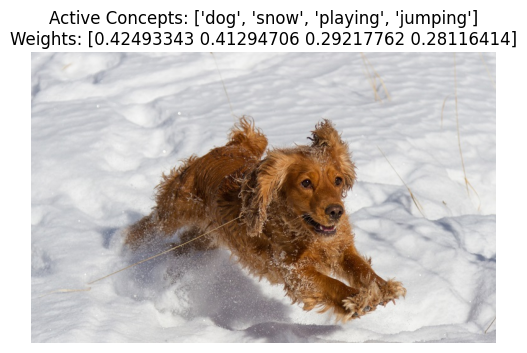

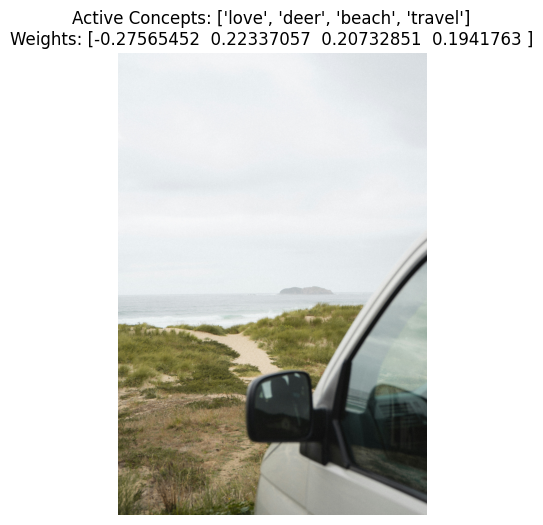

In [12]:
import torch
from sklearn.linear_model import Lasso
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms


# Function to process a single image path input and extract active concepts
def extract_concepts(image_path, top_k=4):
    # Load the image
    img = Image.open(image_path).convert("RGB")

    # Transform the image to the required format (3, 224, 224)
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]),  # Normalization values from CLIP
    ])

    image_tensor = preprocess(img).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Generate image embedding using the CLIP model
    with torch.no_grad():
        image_embedding = clip_model.get_image_features(image_tensor)  # Shape: (1, 512)
        image_embedding = image_embedding / image_embedding.norm(dim=-1, keepdim=True)  # Normalize

    # Center the image embedding
    centered_image_embedding = image_embedding.cpu().numpy().flatten() - mean_concept_embedding.cpu().numpy().flatten()

    # Apply Lasso regression to get sparse weights
    lasso = Lasso(alpha=1e-5, fit_intercept=False, max_iter=1000)
    lasso.fit(Ac, centered_image_embedding)
    sparse_weights = lasso.coef_

    # Get active concepts (non-zero coefficients)
    active_concepts_indices = np.nonzero(sparse_weights)[0]

    # Limit to top_k active concepts based on absolute weights
    top_indices = np.argsort(np.abs(sparse_weights[active_concepts_indices]))[-top_k:][::-1]
    limited_indices = active_concepts_indices[top_indices]

    active_concepts = [concept_words[i] for i in limited_indices]
    active_weights = sparse_weights[limited_indices]

    return img, active_concepts, active_weights

# Example usage with the dummy image
image_paths = ["dummy_img.jpg", "dummy_img_2.jpg"]
for image_path in image_paths:
  image, active_concepts, weights = extract_concepts(image_path)

  # Plotting the result
  plt.figure(figsize=(6, 6))
  plt.imshow(image)
  plt.axis('off')
  plt.title(f'Active Concepts: {active_concepts}\nWeights: {weights}')
  plt.show()